# import stuff

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score, classification_report
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import keras_models.dataGen as dg 

Using TensorFlow backend.


## Pull in data

In [2]:
train_edss = pkl.load(open("/n/scratch2/ms994/train_multiple_labels_sessions_seizure_data_4.pkl", "rb"))

In [3]:
train_seizure_labels = [datum[1][0] for datum in train_edss]
train_session_labels = [datum[1][1] for datum in train_edss]
train_subtype_labels = [datum[1][2] for datum in train_edss]

In [4]:
train_edg = dg.EdfDataGenerator(train_edss, precache=True, labels=train_seizure_labels, shuffle=False, batch_size=512, n_classes=2)

In [5]:
valid_edss = pkl.load(open("/n/scratch2/ms994/valid_multiple_labels_sessions_seizure_data_4.pkl", "rb"))

In [6]:
valid_seizure_labels = [datum[1][0] for datum in valid_edss]
valid_session_labels = [datum[1][1] for datum in valid_edss]
valid_subtype_labels = [datum[1][2] for datum in valid_edss]

In [7]:
valid_edg = dg.EdfDataGenerator(valid_edss, precache=True, labels=valid_seizure_labels, shuffle=False, batch_size=512)

In [8]:
from keras.models import load_model

In [9]:
model = load_model("/n/scratch2/ms994/out/UMEPVXFQHNWCHTKS.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 21, 4)  20          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 500, 21, 4)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 21, 4)   16          max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

# Predict train and try to correlate that with different metrics we see in the data it predicts from

## predict here (exp 6538)

In [11]:
pred = model.predict_generator(train_edg)

In [12]:
val_pred = model.predict_generator(valid_edg)

In [13]:
from addict import Dict

In [14]:
cachedAnalysisResults = Dict()

In [15]:
cachedAnalysisResults.trainMaxPerSegment = [datum[0].max() for datum in train_edss]
cachedAnalysisResults.trainMinPerSegment = [datum[0].min() for datum in train_edss]
cachedAnalysisResults.trainStdPerSegment = [datum[0].std() for datum in train_edss]
cachedAnalysisResults.trainMeanPerSegment = [datum[0].mean() for datum in train_edss]

cachedAnalysisResults.validMaxPerSegment = [datum[0].max() for datum in valid_edss]
cachedAnalysisResults.validMinPerSegment = [datum[0].min() for datum in valid_edss]
cachedAnalysisResults.validStdPerSegment = [datum[0].std() for datum in valid_edss]
cachedAnalysisResults.validMeanPerSegment = [datum[0].mean() for datum in valid_edss]

In [16]:
cachedAnalysisResults.train_seizure_labels = train_seizure_labels
cachedAnalysisResults.train_session_labels = train_session_labels
cachedAnalysisResults.train_subtype_labels = train_subtype_labels


In [17]:
cachedAnalysisResults.valid_seizure_labels = valid_seizure_labels
cachedAnalysisResults.valid_session_labels = valid_session_labels
cachedAnalysisResults.valid_subtype_labels = valid_subtype_labels


In [18]:
cachedAnalysisResults.pred = pred
cachedAnalysisResults.val_pred = val_pred

In [33]:
def save_cached():
    global cachedAnalysisResults
    pkl.dump(cachedAnalysisResults, open("/n/scratch2/ms994/exp6538Analysis.pkl", "wb"))

In [44]:
save_cached()

In [2]:
cachedAnalysisResults = pkl.load(open("/n/scratch2/ms994/exp6538Analysis.pkl", "rb"))

In [3]:
cachedAnalysisResults.keys()

dict_keys(['trainMaxPerSegment', 'trainMinPerSegment', 'trainStdPerSegment', 'trainMeanPerSegment', 'validMaxPerSegment', 'validMinPerSegment', 'validStdPerSegment', 'validMeanPerSegment', 'train_seizure_labels', 'train_session_labels', 'train_subtype_labels', 'valid_seizure_labels', 'valid_session_labels', 'valid_subtype_labels', 'pred', 'val_pred'])

In [22]:
seizDetectPred = cachedAnalysisResults.pred[0].argmax(1)

In [23]:
print(classification_report(seizDetectPred, train_seizure_labels, output_dict=False))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    108175
           1       0.89      0.75      0.81     24608

    accuracy                           0.94    132783
   macro avg       0.92      0.86      0.89    132783
weighted avg       0.93      0.94      0.93    132783



## see the error rate per session

In [24]:
train_pred_errors_per_session = pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()
train_false_alarms_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == False)].value_counts()
train_missed_seizures_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == True)].value_counts()

In [28]:
train_fail_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_false_alarms_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == False)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_missed_seizures_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == True)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

In [31]:
valid_pred_errors_per_session = pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()
valid_false_alarms_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == False)].value_counts()
valid_missed_seizures_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == True)].value_counts()

In [32]:
valid_fail_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_false_alarms_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == False)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_missed_seizures_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == True)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

### Compare to seizure rate per session

In [90]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
    
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(valid_seizure_labels)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

In [59]:
len([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))])

10

In [85]:
import matplotlib.colors as mcolors
import numpy as np

clist = [(0, "red"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 60
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'Seizure Rate for Each Session')

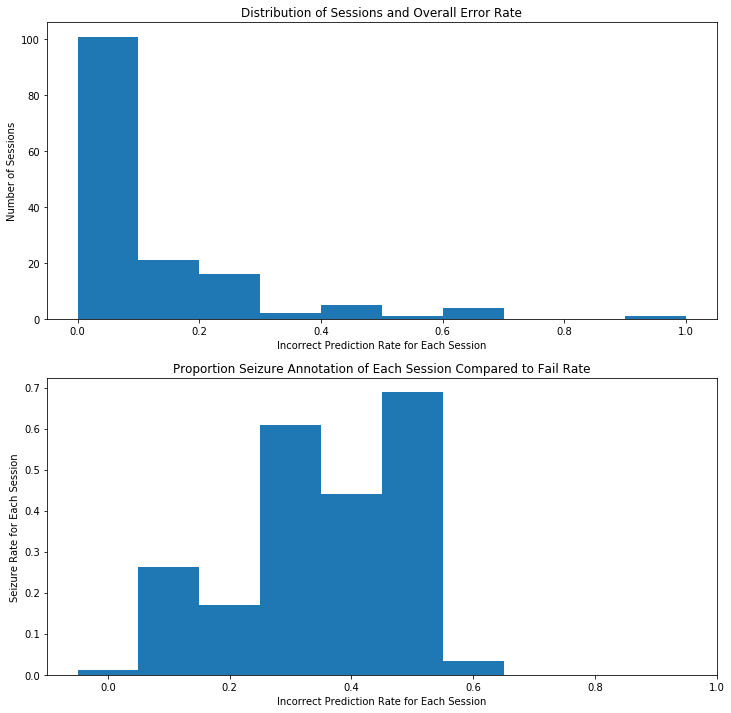

In [91]:
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Error Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

In [75]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(train_seizure_labels)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'Seizure Rate for Each Session')

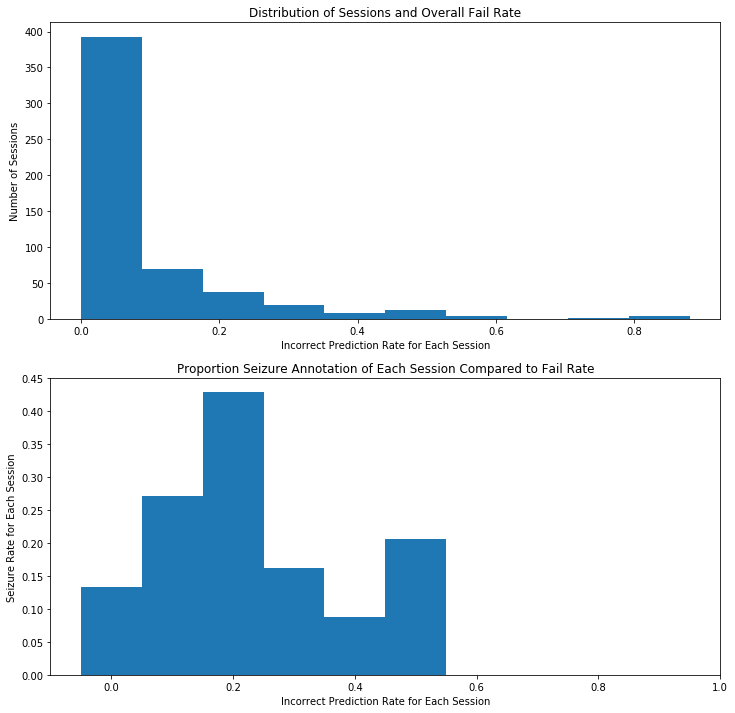

In [79]:
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'Seizure Rate for Each Session')

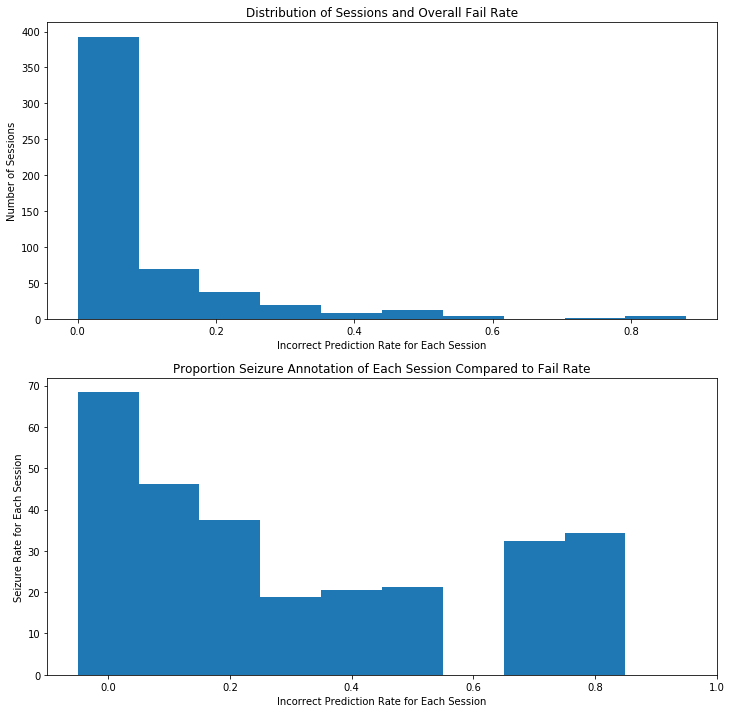

In [93]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.trainStdPerSegment)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'Seizure Rate for Each Session')

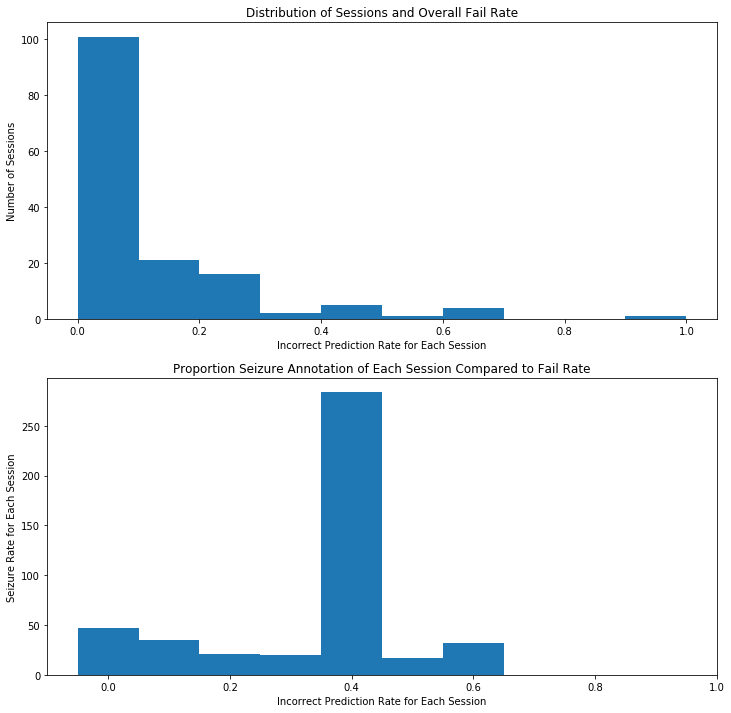

In [94]:
bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.validStdPerSegment)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

(array([15763., 12698.,  4486.,  1278.,   610.,   450.,   412.,   324.,
          220.,   184.,   287.,   165.,   111.,    70.,    79.,    86.,
          146.,    69.,    51.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

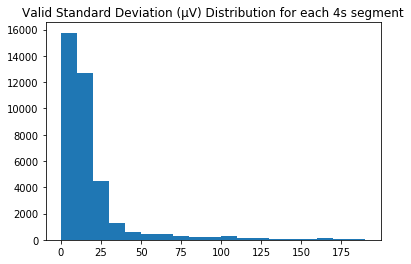

In [99]:
plt.title("Valid Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.validStdPerSegment, bins=[10*i for i in range(20)])

(array([41511., 50780., 15659.,  5093.,  2120.,  1394.,  1363.,  1483.,
         1075.,   616.,   610.,   623.,   358.,   474.,   628.,   365.,
          433.,   254.,   238.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

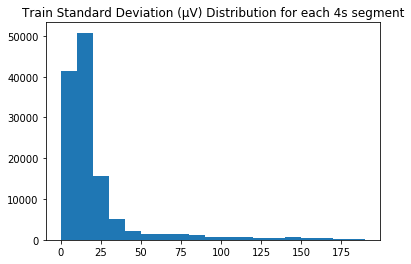

In [100]:
plt.title("Train Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.trainStdPerSegment, bins=[10*i for i in range(20)])

In [9]:
full_df = pd.DataFrame([cachedAnalysisResults.trainStdPerSegment, cachedAnalysisResults.train_seizure_labels, cachedAnalysisResults.train_session_labels], index=["std", "seiz", "sess"]).T

In [28]:
full_df["std"] = full_df["std"].astype(np.float)

In [31]:
sbs = pd.DataFrame([full_df.groupby("sess")["std"].mean(), full_df.groupby("sess")["seiz"].sum()/full_df.groupby("sess")["seiz"].count()]).T

In [33]:
sbs

,std,seiz
sess,,
00000077/s003_2010_01_21,29.194767,0.000000
00000254/s005_2010_11_15,6.273648,0.000000
00000254/s006_2011_07_01,5.377775,0.000000
00000254/s007_2013_03_25,26.027723,0.000000
00000458/s005_2003_02_12,23.536660,0.000000
00000458/s011_2014_06_24,15.545072,0.000000
00000458/s012_2014_06_25,19.902327,0.000000
00000492/s003_2003_07_18,17.604735,0.187935
00000529/s004_2012_06_05,9.701745,0.000000


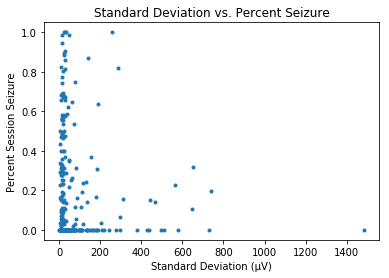

In [40]:
plt.title("Standard Deviation vs. Percent Seizure")
plt.xlabel("Standard Deviation (µV)")
plt.ylabel("Percent Session Seizure")
plt.plot(sbs["std"], sbs.seiz, ".")

In [24]:
full_df.head()["std"].dtype

dtype('O')

# Exp 6601

In [9]:
model = load_model("/n/scratch2/ms994/out/IOGUDCALURHXBFMW.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [12]:
pred = model.predict_generator(train_edg)
val_pred = model.predict_generator(valid_edg)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars


NameError: name 'cachedAnalysisResults' is not defined

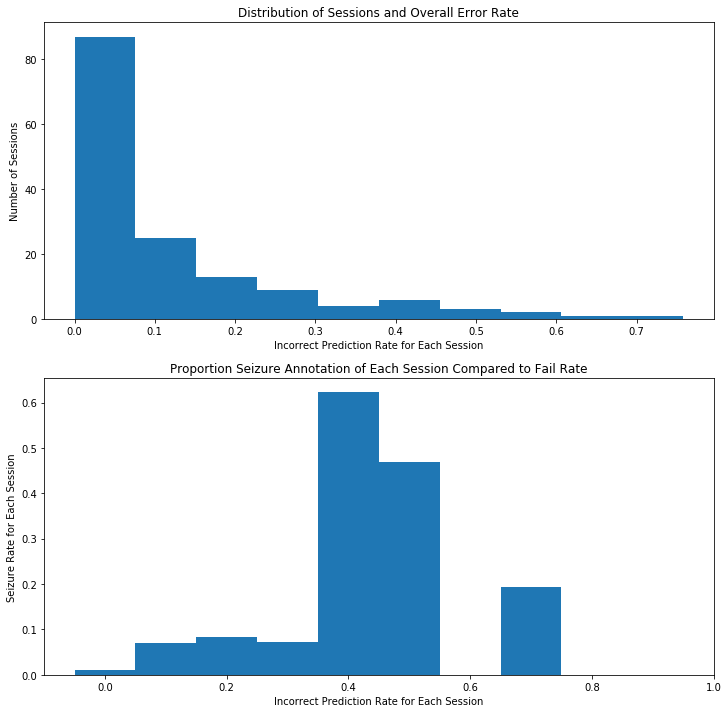

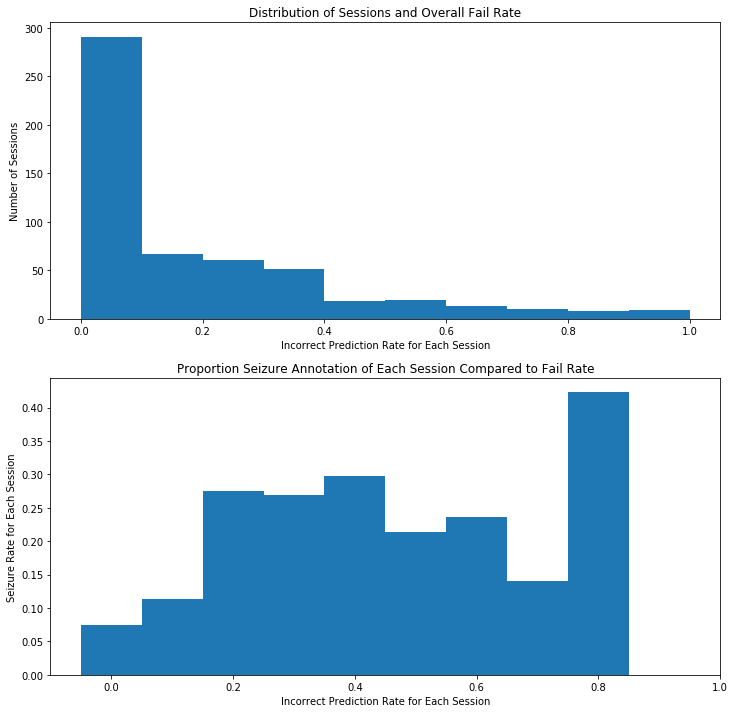

In [13]:
train_pred_errors_per_session = pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()
train_false_alarms_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == False)].value_counts()
train_missed_seizures_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == True)].value_counts()

train_fail_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_false_alarms_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == False)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_missed_seizures_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == True)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

valid_pred_errors_per_session = pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()
valid_false_alarms_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == False)].value_counts()
valid_missed_seizures_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == True)].value_counts()

valid_fail_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_false_alarms_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == False)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_missed_seizures_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == True)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

### Compare to seizure rate per session

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
    
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(valid_seizure_labels)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

len([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))])

import matplotlib.colors as mcolors
import numpy as np

clist = [(0, "red"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 60
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Error Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(train_seizure_labels)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)
plt.show()


ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.trainStdPerSegment)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.validStdPerSegment)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

plt.title("Valid Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.validStdPerSegment, bins=[10*i for i in range(20)])

plt.title("Train Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.trainStdPerSegment, bins=[10*i for i in range(20)])

In [15]:
valid_fail_per_session_rate

00013095/s001_2015_10_09    0.758065
00007038/s001_2010_10_03    0.640000
00010587/s001_2013_08_07    0.542484
00001543/s002_2004_07_16    0.536723
00006904/s007_2010_08_21    0.505710
00006904/s005_2010_08_21    0.461131
00013145/s004_2015_09_01    0.457627
00009623/s011_2012_11_09    0.450450
00006904/s008_2010_08_22    0.441606
00011379/s001_2014_01_21    0.440000
00007584/s004_2011_03_06    0.434343
00006904/s004_2010_08_20    0.418935
00008829/s002_2012_03_29    0.380000
00002991/s003_2010_04_26    0.371622
00013145/s006_2015_09_03    0.326861
00006535/s006_2012_07_19    0.319224
00012679/s001_2015_06_25    0.305556
00012229/s006_2014_11_19    0.289272
00000272/s008_2003_07_03    0.281690
00002806/s001_2004_12_23    0.274448
00007795/s005_2015_12_15    0.268116
00009994/s007_2013_03_15    0.267857
00008829/s001_2012_03_28    0.254717
00010480/s003_2013_07_16    0.250000
00006103/s005_2010_10_31    0.246575
00008092/s005_2013_06_01    0.239437
00010480/s024_2013_07_28    0.226000
0

In [50]:
%%bash
ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/00013095_s001_t001.tse
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/00013095_s001.txt

00013095_s001.txt
00013095_s001_t001.edf
00013095_s001_t001.lbl
00013095_s001_t001.lbl_bi
00013095_s001_t001.tse
00013095_s001_t001.tse_bi
version = tse_v1.0.0

0.0000 502.0200 bckg 1.0000
502.0200 550.0120 fnsz 1.0000
550.0120 1332.0000 bckg 1.0000
History:	75 year old woman with progressive worsening of mental status.  Facial twitching
(unspecified side) was noted earlier today.
Medications:	Ativan (given several hours earlier)
Sedation:
EEG Type:	Asleep only, portable
Technique:	International 10-20 System; standard 21 electrodes with T1/T2 electrodes and EKG
electrodes, obtunded
Description:
There is right-to-left interhemispheric asymmetry with slower waveforms over the right.  There is no
PDR or AP gradient.  The background over the left consists of a mixture of moderate amplitude
theta and delta activity with underriding fast activity.  Delta activity is most pronounced anteriorly.
The background over the right consists of a mixture of moderate amplitude theta and delta activity,

In [38]:
read.file_list_lock.release()

ValueError: semaphore or lock released too many times

In [2]:
from pyedflib import EdfReader

In [3]:
data = read.edf_eeg_2_df("/home/ms994/v1.5.0/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/00013095_s001_t001.edf")

In [73]:
data.shape[0]/500

666.0

In [78]:
data - data.mean(1)

MemoryError: 

In [6]:
data.index[0:10000]

TimedeltaIndex([       '00:00:00', '00:00:00.004000', '00:00:00.008000',
                '00:00:00.012000', '00:00:00.016000', '00:00:00.020000',
                '00:00:00.024000', '00:00:00.028000', '00:00:00.032000',
                '00:00:00.036000',
                ...
                '00:00:39.960000', '00:00:39.964000', '00:00:39.968000',
                '00:00:39.972000', '00:00:39.976000', '00:00:39.980000',
                '00:00:39.984000', '00:00:39.988000', '00:00:39.992000',
                '00:00:39.996000'],
               dtype='timedelta64[ns]', length=10000, freq=None)

In [32]:
10000/constants.COMMON_FREQ

40.0

In [48]:
data.shape[0]/250/60

22.2

In [52]:
[data.shape[0]*i/constants.COMMON_FREQ/60/8 for i in range(9)]

[0.0, 2.775, 5.55, 8.325, 11.1, 13.875, 16.65, 19.425, 22.2]

([<matplotlib.axis.XTick at 0x7f3973083438>,
 <a list of 7 Text xticklabel objects>)

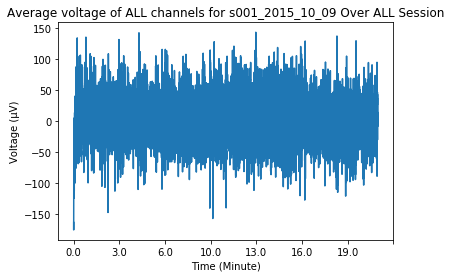

In [66]:
plt.plot(data.mean(1))
plt.title("Average voltage of ALL channels for s001_2015_10_09 Over ALL Session")
plt.ylabel("Voltage (µV)")
plt.xlabel("Time (Minute)")
locs, labels= plt.xticks()
plt.xticks(locs[1:], [np.round(data.shape[0]*i/constants.COMMON_FREQ/60/7) for i in range(7)])

In [60]:
labels[-1]

Text(1400000000000.0, 0, '1.4')

# Exp 6639

In [11]:
history=Dict({
    "train_f1" : [ 
        0.729782462120056, 
        0.76562488079071, 
        0.771827459335327, 
        0.785868763923645, 
        0.795476019382477, 
        0.803684413433075, 
        0.808171331882477, 
        0.816168606281281, 
        0.820338785648346, 
        0.82519519329071, 
        0.826963603496552, 
        0.826910793781281, 
        0.828863918781281, 
        0.83345639705658, 
        0.835858225822449, 
        0.836043000221252, 
        0.834564924240112, 
        0.836201310157776, 
        0.836834788322449, 
        0.840793788433075, 
        0.841453671455383, 
        0.840318739414215, 
        0.843829095363617, 
        0.845887780189514, 
        0.846758782863617, 
        0.846574008464813, 
        0.849266171455383, 
        0.846653163433075, 
        0.84689074754715, 
        0.850031554698944, 
        0.850005149841309, 
        0.850744187831879, 
        0.851140081882477, 
        0.850242733955383, 
        0.851615190505981, 
        0.854650437831879, 
        0.851404011249542, 
        0.854386508464813, 
        0.856075704097748, 
        0.85689389705658, 
        0.853990614414215, 
        0.856682777404785, 
        0.855072736740112, 
        0.853357136249542, 
        0.855442225933075, 
        0.857500970363617, 
        0.857976019382477, 
        0.856577157974243, 
        0.857342600822449, 
        0.857896864414215, 
        0.857342600822449, 
        0.859665215015411, 
        0.858715057373047, 
        0.858530282974243, 
        0.861011326313019, 
        0.856524407863617, 
        0.859797179698944, 
        0.859876394271851, 
        0.863254725933075, 
        0.86103767156601, 
        0.862119853496552, 
        0.86153918504715, 
        0.86153918504715, 
        0.858715057373047, 
        0.860879302024841, 
        0.861618340015411, 
        0.862251818180084, 
        0.865023136138916, 
        0.86349231004715, 
        0.86103767156601, 
        0.863360345363617, 
        0.860905706882477, 
        0.862700462341309, 
        0.864917576313019, 
        0.862542152404785, 
        0.864864766597748, 
        0.865102291107178, 
        0.861512780189514, 
        0.86177670955658, 
        0.862172603607178, 
        0.863756239414215, 
        0.863677024841309, 
        0.862225413322449, 
        0.862647712230682, 
        0.86275327205658, 
        0.866237223148346, 
        0.862040638923645, 
        0.863439500331879, 
        0.865207850933075, 
        0.864864766597748, 
        0.863914608955383, 
        0.865181505680084, 
        0.864759206771851, 
        0.86592048406601, 
        0.866237223148346, 
        0.865867733955383, 
        0.867820858955383, 
        0.869879543781281, 
        0.866791486740112, 
        0.866553962230682
    ],
    "valid_f1" : [ 
        0.400732459521974, 
        0.437682032740785, 
        0.478175383405427, 
        0.497775018110318, 
        0.501778997661889, 
        0.53661602933473, 
        0.510656080234016, 
        0.543638525564804, 
        0.543816219427666, 
        0.548380647740904, 
        0.541207670338637, 
        0.551779772108501, 
        0.502037923090555, 
        0.603868982193889, 
        0.562590224788616, 
        0.583360593174136, 
        0.548648384893139, 
        0.521544069539209, 
        0.549496981891348, 
        0.566984876112839, 
        0.573051109963862, 
        0.574575204531152, 
        0.510998952480716, 
        0.598993655655218, 
        0.493000177210704, 
        0.548136336456049, 
        0.591779034362766, 
        0.559021161367967, 
        0.563282051282051, 
        0.562198748846272, 
        0.610764872521246, 
        0.569347622515867, 
        0.631675874769797, 
        0.610081958010554, 
        0.606726457399103, 
        0.566402633473922, 
        0.612928611579539, 
        0.596261896571494, 
        0.596891191709845, 
        0.608862762830658, 
        0.628902554399243, 
        0.570956413964057, 
        0.566457023060797, 
        0.496146788990826, 
        0.617246944892783, 
        0.624743512371756, 
        0.623778889683107, 
        0.610624775152896, 
        0.597254770672916, 
        0.521595971334495, 
        0.547073536768384, 
        0.59927797833935, 
        0.656335460346399, 
        0.601282798833819, 
        0.589762850091212, 
        0.631406888499708, 
        0.561669435215947, 
        0.620250177012037, 
        0.683513838748496, 
        0.579449501041781, 
        0.646749583279908, 
        0.665502418054809, 
        0.611217183770883, 
        0.636487964989059, 
        0.63066243087422, 
        0.618858858858859, 
        0.651774317079398, 
        0.660075198440329, 
        0.661359780764713, 
        0.671300081766149, 
        0.640666949272291, 
        0.64131203166973, 
        0.574663985606942, 
        0.617742908871454, 
        0.599139882299683, 
        0.684380900998112, 
        0.574374725756911, 
        0.645404747413268, 
        0.691958762886598, 
        0.670797626895188, 
        0.69601913067942, 
        0.614077952297848, 
        0.624357656731757, 
        0.63734243697479, 
        0.632828810020877, 
        0.570301048596234, 
        0.611229566453447, 
        0.653957105230152, 
        0.608368829867201, 
        0.632713554298033, 
        0.650644202180377, 
        0.645998361103524, 
        0.532744231713304, 
        0.68237831176833, 
        0.547629310344828, 
        0.656152986464672, 
        0.616489988221437, 
        0.681646932185145, 
        0.680775044661261, 
        0.651716711009755
    ]
})

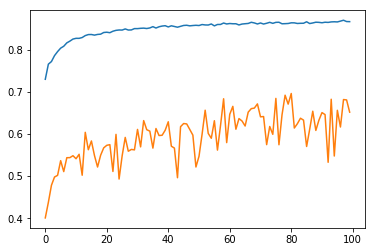

In [12]:
plt.plot(history.train_f1)
plt.plot(history.valid_f1)
plt.legend(["Train", "Valid"])


# Exp 6654

In [9]:
model = load_model("/n/scratch2/ms994/out/BRKYARDOABJMKVOO.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
pred = model.predict_generator(train_edg)
val_pred = model.predict_generator(valid_edg)

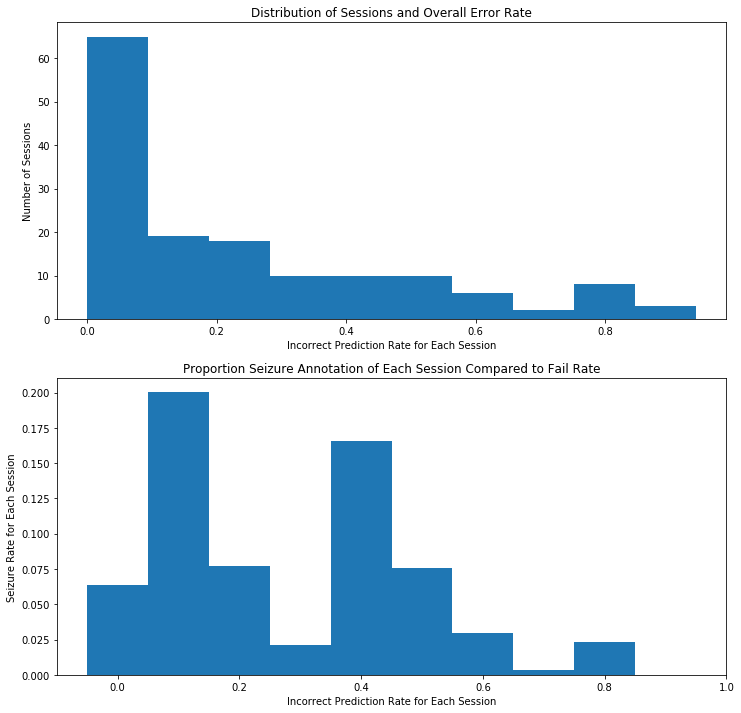

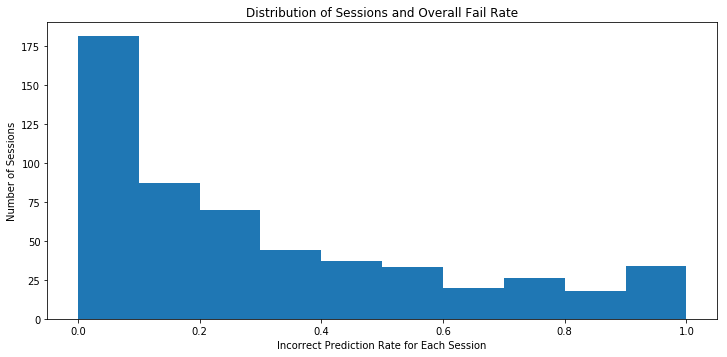

NameError: name 'cachedAnalysisResults' is not defined

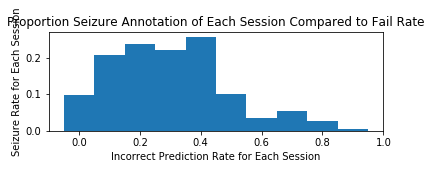

In [11]:
train_pred_errors_per_session = pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()
train_false_alarms_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == False)].value_counts()
train_missed_seizures_per_session = pd.Series(train_session_labels)[(train_seizure_labels!=pred[0].argmax(1)) & (np.array(train_seizure_labels) == True)].value_counts()

train_fail_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_false_alarms_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == False)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
train_missed_seizures_per_session_rate = (pd.Series(train_session_labels)[train_seizure_labels!=pred[0].argmax(1) & (np.array(train_seizure_labels) == True)].value_counts()/pd.Series(train_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

valid_pred_errors_per_session = pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()
valid_false_alarms_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == False)].value_counts()
valid_missed_seizures_per_session = pd.Series(valid_session_labels)[(valid_seizure_labels!=val_pred[0].argmax(1)) & (np.array(valid_seizure_labels) == True)].value_counts()

valid_fail_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_false_alarms_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == False)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)
valid_missed_seizures_per_session_rate = (pd.Series(valid_session_labels)[valid_seizure_labels!=val_pred[0].argmax(1) & (np.array(valid_seizure_labels) == True)].value_counts()/pd.Series(valid_session_labels).value_counts()).sort_values(ascending=False).fillna(0)

### Compare to seizure rate per session

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
    
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(valid_seizure_labels)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

len([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))])

import matplotlib.colors as mcolors
import numpy as np

clist = [(0, "red"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

N = 60
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Error Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(train_seizure_labels)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])

figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)
plt.show()


ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (train_fail_per_session_rate > bins_fail[i]) & (train_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.trainStdPerSegment)[pd.Series(train_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(train_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

bins_fail = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
seizure_label_bins = []
for i in range(len(bins_fail)-1):
    sliced_sessions = (valid_fail_per_session_rate > bins_fail[i]) & (valid_fail_per_session_rate < bins_fail[i+1])
#     seizure_label_bins.append(sliced_sessions)

    seizure_label_bins.append(pd.Series(cachedAnalysisResults.validStdPerSegment)[pd.Series(valid_session_labels).apply(lambda session_label: sliced_sessions[session_label])])
    
figure = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 1)
ax.set_title( "Distribution of Sessions and Overall Fail Rate")

ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Number of Sessions")
histogram = plt.hist(valid_fail_per_session_rate)



ax = plt.subplot(2, 1, 2)
plt.bar(height=pd.Series([seizure_label_bins[i].sum()/seizure_label_bins[i].shape[0] for i in range(len(seizure_label_bins))]).fillna(0), x=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,], width=0.1)
ax.set_title("Proportion Seizure Annotation of Each Session Compared to Fail Rate")
ax.set_xlabel("Incorrect Prediction Rate for Each Session")
ax.set_ylabel("Seizure Rate for Each Session")

plt.title("Valid Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.validStdPerSegment, bins=[10*i for i in range(20)])

plt.title("Train Standard Deviation (µV) Distribution for each 4s segment")
plt.hist(cachedAnalysisResults.trainStdPerSegment, bins=[10*i for i in range(20)])

In [12]:
valid_pred_errors_per_session

00011379/s003_2014_01_22    379
00009623/s005_2012_10_20    372
00010549/s006_2013_08_14    369
00011379/s002_2014_01_21    324
00013145/s005_2015_09_02    278
00010549/s005_2013_08_13    276
00007795/s005_2015_12_15    262
00009623/s004_2012_10_19    251
00013145/s004_2015_09_01    233
00010587/s002_2013_08_07    203
00013145/s006_2015_09_03    199
00011379/s004_2014_01_23    186
00009623/s002_2012_10_18    170
00002806/s001_2004_12_23    165
00009623/s006_2012_10_21    160
00009623/s003_2012_10_19    151
00007795/s007_2015_12_17    141
00010480/s024_2013_07_28    136
00006904/s008_2010_08_22    122
00001543/s002_2004_07_16    121
00010480/s013_2013_07_22    114
00013145/s007_2015_09_04    112
00007795/s009_2015_12_19    108
00009994/s008_2013_03_15    101
00007795/s006_2015_12_16     98
00010480/s023_2013_07_27     97
00012229/s006_2014_11_19     91
00006904/s004_2010_08_20     88
00009623/s011_2012_11_09     88
00007929/s007_2014_08_12     88
                           ... 
00009528

In [64]:
%%bash
# ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/00011379_s003.txt
# cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/00011379_s003_t000.lbl
# cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/00011379_s003_t000.tse


CLINICAL HISTORY:  60-year-old with episodic unresponsiveness characterized by head shaking lasting 20 minutes.  Spell may be associated with incontinence.  Associated alcohol abuse, left hemiparesis, depression and psychiatric illness.
MEDICATIONS:  Keppra, Ativan, metoprolol, Dilaudid, midazolam, others.
INTRODUCTION:  Continuous video EEG monitoring was performed in the unit using standard 10-20 system of electrode placement with 1 channel EKG.  The patient was at times a bit confused, but no clinical seizures were recorded.  Seizure and spike detection software was utilized.
DESCRIPTION OF RECORD:  The background EEG includes an awake and drowsy pattern.
Wakefulness:  In wakefulness there is generous beta noted.  There is a glimpse of an underlying posterior dominant rhythm.   Focal slowing was noted from the right hemisphere with right mid to posterior temporal sharp waves.
Interictal epileptiform detections:  Frequent epileptiform activity was noted, particularly in sleep.  The s

In [14]:
data = read.edf_eeg_2_df("/home/ms994/v1.5.0/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/00011379_s003_t000.edf")

In [26]:
data[util_funcs.get_common_channel_names()].values[:,0].shape

(77099,)

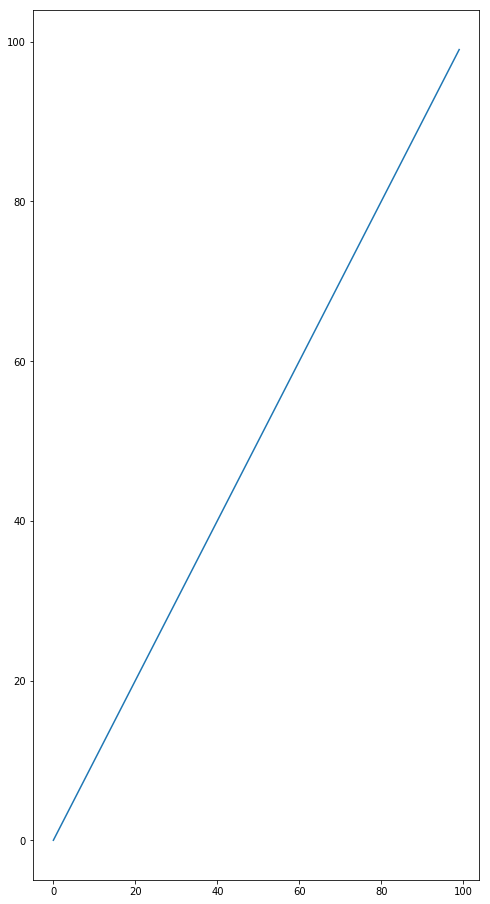

In [32]:
plt.figure(figsize=(8,16))
plt.plot([i for i in range(100)], [i for i in range(100)])

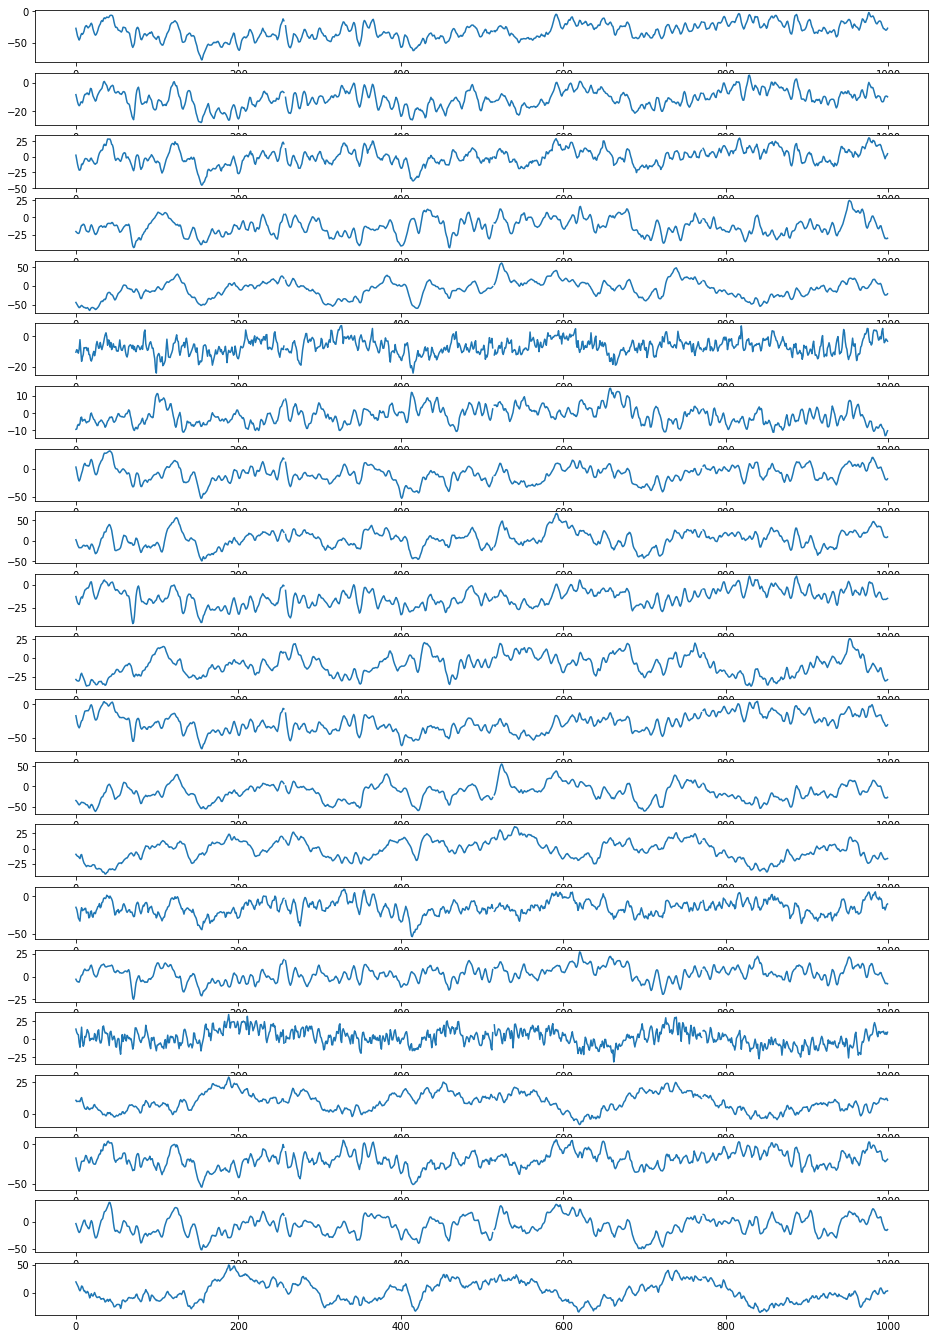

In [36]:
plt.figure(figsize=(16,24))

for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(data[util_funcs.get_common_channel_names()].values[0:1000,i])

In [57]:
model.predict(data[util_funcs.get_common_channel_names()].values[i:i+1000].reshape(1, 1000, 21, 1)/1.75)[0].argmax(1)[0]

0

In [61]:
data[util_funcs.get_common_channel_names()].fillna(0).values[i:i+1000].reshape(1, 1000, 21, 1).std()

36.422943

In [66]:
%%bash
# ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/00009623_s005.txt

REASON FOR STUDY:  Seizures.
CLINICAL HISTORY:  A 61-year-old man with history of alcohol abuse with new onset of focal seizures and right upper extremity shaking, eyes deviating to the left with increased seizure frequency.
MEDICATIONS:  Dilantin.
INTRODUCTION:  A long term EEG was performed from October 20, 2012 to October 21, 2012 for 24-hours using the standard 10-20 electrode placement system with additional anterior temporal and single lead EKG electrode.  The patient was recorded during wakefulness and obtundation.  The patient had no activating procedures performed.
TECHNICAL DIFFICULTIES:  None.
DESCRIPTION OF THE RECORD:  The record opens to a diffusely slow background with no normal posterior dominant rhythm or frontal central beta.  The overall background is slow with a theta frequency and at times with bursts of intermittent beta bursts seen diffusely.  No normal sleep architecture is seen.  No activating procedures were performed.
Abnormal discharges:
Focal sharp waves se

In [67]:
data = read.edf_eeg_2_df("/home/ms994/v1.5.0/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/00009623_s005_t000.edf")

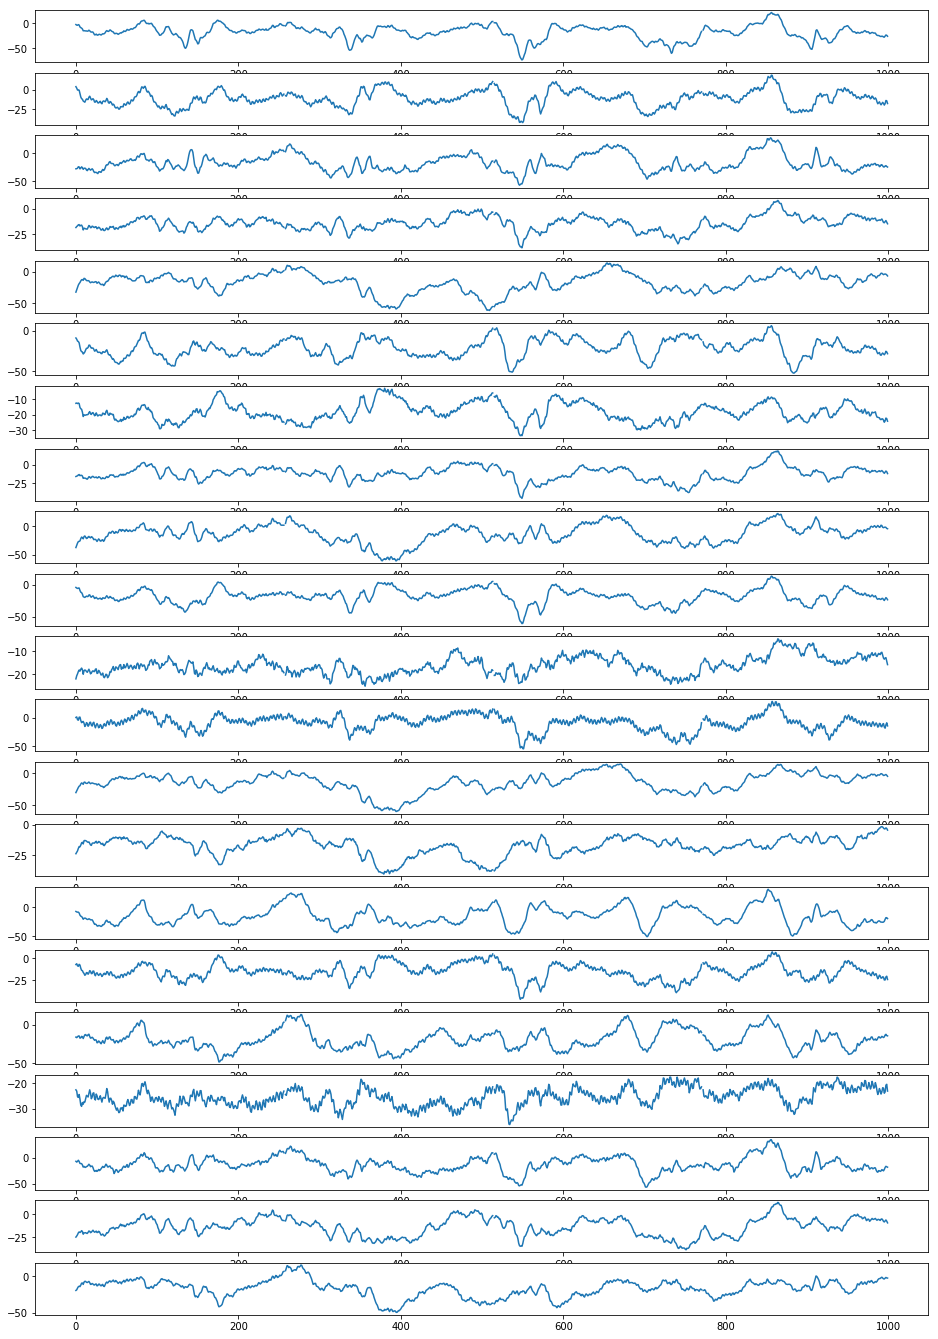

In [68]:
plt.figure(figsize=(16,24))

for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(data[util_funcs.get_common_channel_names()].values[0:1000,i])

In [76]:
valid_false_alarms_per_session

00011379/s003_2014_01_22    379
00009623/s005_2012_10_20    370
00010549/s006_2013_08_14    369
00011379/s002_2014_01_21    324
00013145/s005_2015_09_02    278
00010549/s005_2013_08_13    276
00007795/s005_2015_12_15    262
00009623/s004_2012_10_19    251
00013145/s004_2015_09_01    231
00010587/s002_2013_08_07    203
00013145/s006_2015_09_03    199
00011379/s004_2014_01_23    186
00009623/s002_2012_10_18    170
00009623/s006_2012_10_21    160
00002806/s001_2004_12_23    157
00009623/s003_2012_10_19    151
00007795/s007_2015_12_17    141
00010480/s024_2013_07_28    136
00001543/s002_2004_07_16    121
00010480/s013_2013_07_22    114
00013145/s007_2015_09_04    112
00007795/s009_2015_12_19    108
00009994/s008_2013_03_15    101
00007795/s006_2015_12_16     98
00010480/s023_2013_07_27     97
00012229/s006_2014_11_19     91
00007929/s007_2014_08_12     88
00009623/s011_2012_11_09     88
00009623/s012_2012_11_10     86
00007795/s008_2015_12_18     77
                           ... 
00003437

In [75]:

model.predict(data[util_funcs.get_common_channel_names()].values[i:i+1000].reshape(1, 1000, 21, 1))

[array([[0.9691928 , 0.03080715]], dtype=float32),
 array([[0.05181315, 0.02612619, 0.10414992, 0.04979647, 0.08906834,
         0.01862411, 0.02786554, 0.17383474, 0.0397201 , 0.03657647,
         0.38242498]], dtype=float32)]